In [1]:
import os
import numpy as np
import pandas as pd
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import *
from keras import optimizers
import matplotlib.pyplot as plt
import nltk  
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ReduceLROnPlateau
from tqdm import tqdm
import seaborn as sns

Using TensorFlow backend.


In [2]:
import io
import zipfile

dim=300
embedding_dict={}

with zipfile.ZipFile("../input/quora-insincere-questions-classification/embeddings.zip") as zf:
    with io.TextIOWrapper(zf.open("glove.840B.300d/glove.840B.300d.txt"), encoding="utf-8") as f:
        for line in tqdm(f):
            values=line.split(' ') # ".split(' ')" only for glove-840b-300d; for all other files, ".split()" works
            word=values[0]
            vectors=np.asarray(values[1:],'float32')
            embedding_dict[word]=vectors

2196017it [06:17, 5812.19it/s]


In [3]:
print('Found %s word vectors.' % len(embedding_dict))

Found 2196016 word vectors.


In [4]:
def plot_accuracy_epoch(epochs,metric1,metric2):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Training Loss', color=color)
    ax1.plot(epochs, metric1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    
    color = 'tab:blue'
    ax2.set_ylabel('Validation Loss', color=color)  # we already handled the x-label with ax1
    ax2.plot(epochs, metric2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title('Training and Validation set losses')
    plt.show()

def plot_zoom(from_epoch,metric1,metric2):
    epochs_zoom = epochs[from_epoch:]
    metric1_zoom = metric1[from_epoch:]
    metric2_zoom = metric2[from_epoch:]

    plot_accuracy_epoch(epochs_zoom,metric1_zoom,metric2_zoom)  
    

def text_cleaner(text):
    text = text.lower()
    text = re.sub(r"\n"," ",text)
    text = re.sub('@[^\s]+','',text)
    text = re.sub(r"\d+",'',text)        #Remove digits
    text = text.translate(str.maketrans('','', string.punctuation)) #remove punctuations
    text = re.sub(r'http\S+|www.\S+', r' ', text) #Remove http
    text= text.strip()
    return text

seed=12


In [23]:
train_data=pd.read_csv("../input/quora-insincere-questions-classification/train.csv")
test_data=pd.read_csv("../input/quora-insincere-questions-classification/test.csv")
submission=pd.read_csv("../input/quora-insincere-questions-classification/sample_submission.csv")

In [9]:
train_data['cleaned'] = train_data['question_text'].apply(lambda x : text_cleaner(x))
test_data['cleaned'] = test_data['question_text'].apply(lambda x : text_cleaner(x))

train_features = train_data['cleaned'].to_numpy()
train_label = train_data['target'].to_numpy()
X_test = test_data['cleaned'].to_numpy()

In [10]:
X_train, X_cv, y_train, y_cv = train_test_split(train_features, train_label, test_size = 0.2, random_state = seed)

In [37]:
vocab_size = 50000
embedding_dim = 300
max_length = 100 #max([max([len(i.split()) for i in X_test]), max([len(i.split()) for i in X_cv]), max([len(i.split()) for i in X_train])])
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
batch_size=32

In [12]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
print(len(word_index))

train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(X_cv)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

full_train_sequences = tokenizer.texts_to_sequences(train_features)
full_train_padded = pad_sequences(full_train_sequences, padding=padding_type, maxlen=max_length)

206971


In [14]:
hits = 0
misses = 0
missed_words=[]
nb_words = min(vocab_size, len(word_index))
embedding_matrix = np.zeros((nb_words , embedding_dim))
for word, i in tqdm(word_index.items(),desc="Loading..."):
    if i >= vocab_size: continue
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        missed_words.append(word)
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Loading...: 100%|██████████| 206971/206971 [00:00<00:00, 511467.10it/s]

Converted 46373 words (3626 misses)


In [42]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length,weights=[embedding_matrix],trainable=False),
    # tf.keras.layers.SpatialDropout1D(0.1),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    #tf.keras.layers.Conv1D(32, kernel_size=3, padding='valid', kernel_initializer='glorot_uniform'),
    #tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.MaxPooling1D(pool_size=2),
    # tf.keras.layers.Conv1D(32, kernel_size=3, padding='valid', kernel_initializer='glorot_uniform'),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=1e-5)
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 100, 64)           85248     
_________________________________________________________________
global_average_pooling1d_9 ( (None, 64)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_37 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_38 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_39 (Dense)             (None, 1)                

In [43]:
num_epochs = 5
history_nn=model.fit(train_padded, y_train, epochs=num_epochs, validation_data=(validation_padded, y_cv),
                     callbacks=[],batch_size=batch_size)

Epoch 1/5
32654/32654 [==============================] - 461s 14ms/step - loss: 0.1145 - accuracy: 0.9550 - val_loss: 0.1073 - val_accuracy: 0.9578
Epoch 2/5
32654/32654 [==============================] - 463s 14ms/step - loss: 0.1026 - accuracy: 0.9593 - val_loss: 0.1066 - val_accuracy: 0.9584
Epoch 3/5
32654/32654 [==============================] - 461s 14ms/step - loss: 0.0976 - accuracy: 0.9612 - val_loss: 0.1048 - val_accuracy: 0.9578
Epoch 4/5
32654/32654 [==============================] - 469s 14ms/step - loss: 0.0934 - accuracy: 0.9627 - val_loss: 0.1034 - val_accuracy: 0.9587
Epoch 5/5
32654/32654 [==============================] - 471s 14ms/step - loss: 0.0898 - accuracy: 0.9640 - val_loss: 0.1042 - val_accuracy: 0.9586


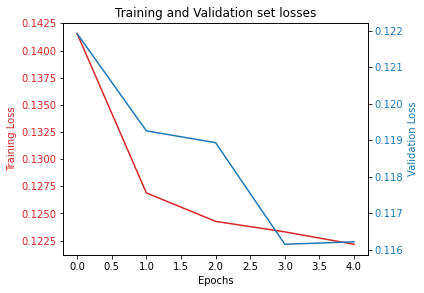

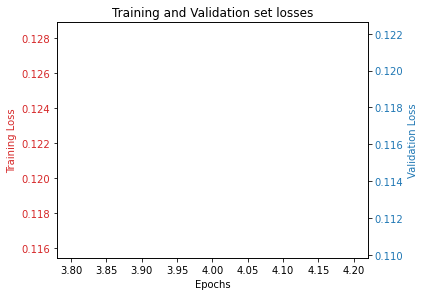

In [17]:
train_loss=history_nn.history['loss']
valid_loss=history_nn.history['val_loss']
epochs=range(len(train_loss))

plot_accuracy_epoch(epochs,train_loss,valid_loss)
plot_zoom(int(0.8*num_epochs),train_loss,valid_loss)

              precision    recall  f1-score   support

           0       0.97      0.98      0.98    245198
           1       0.69      0.60      0.64     16027

    accuracy                           0.96    261225
   macro avg       0.83      0.79      0.81    261225
weighted avg       0.96      0.96      0.96    261225



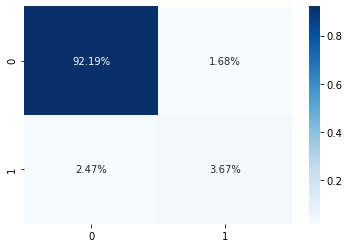

In [54]:
y_pred=(model.predict(validation_padded)>0.5).astype(int)
print(classification_report(y_cv, y_pred))
cf_matrix_lr = confusion_matrix(y_cv, y_pred)
sns.heatmap(cf_matrix_lr/np.sum(cf_matrix_lr), annot=True, fmt='.2%', cmap='Blues')

In [55]:
missed_words[1:20]

['i’m',
 'don’t',
 'what’s',
 'it’s',
 'can’t',
 'quorans',
 'doesn’t',
 'i’ve',
 'isn’t',
 'cryptocurrencies',
 'brexit',
 'you’ve',
 'didn’t',
 'redmi',
 'you’re',
 'kvpy',
 'paytm',
 'iiser',
 'ethereum']

In [ ]:
#num_epochs = 5
#history_nn=model.fit(full_train_padded, train_label, epochs=num_epochs)

In [19]:
testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [28]:
predictions = model.predict(testing_padded)
submission['prediction'] = (predictions > 0.5).astype(int)
submission.to_csv("submission.csv", index=False, header=True)